In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import xarray as xr
import torch
import gpytorch
import matplotlib.pyplot as plt
import tqdm
import cartopy.crs as ccrs
from sklearn.linear_model import LinearRegression
import scienceplots
plt.style.use('science')

base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

import fit_spatial_FaIRGP as fairgp
import fit_spatial_Plain_GP as plaingp
from src.preprocessing.spatial import load_emissions_dataset, load_response_dataset
from src.structures import Scenario, ScenarioDataset
import src.evaluation.visualisation as vis
from src.models.utils_spatial import compute_means
from src.structures import Scenario, ScenarioDataset
from src.preprocessing.spatial.preprocess_data import make_scenario, load_emissions_dataset, load_response_dataset
from src.evaluation.metrics import spearman_correlation

In [3]:
def encapsulate_as_xarray(data, scenario):
    field = xr.DataArray(data=data.cpu(),
                         dims=['time', 'lat', 'lon'],
                         coords=dict(time=scenario.timesteps.cpu(),
                                     lat=scenario.lat.cpu(),
                                     lon=scenario.lon.cpu()))
    return field

def weighted_mean(x, wlat):
    mu = torch.sum(x * wlat, dim=(1, 2)) / (x.size(2) * wlat.sum())
    return mu

In [4]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']}}
train_data = fairgp.make_data(train_cfg)

input_hist_aer = {'hist-aer': load_emissions_dataset('../data/inputs_hist-aer.nc')}
output_hist_aer = {'hist-aer': load_response_dataset('../data/outputs_hist-aer.nc')}
hist_aer = make_scenario(key='hist-aer',
                         inputs=input_hist_aer,
                         outputs=output_hist_aer,
                         hist_scenario=None)
test_scenarios = ScenarioDataset([hist_aer], hist_scenario=None)
test_tas = test_scenarios.tas

encapsulate = lambda data: encapsulate_as_xarray(data, test_scenarios[0])

## Pattern Scaling

In [5]:
scenarios = train_data.scenarios
all_tas = scenarios.tas
wlat = torch.cos(torch.deg2rad(scenarios[0].lat)).clip(min=torch.finfo(torch.float64).eps)[:, None]
glob_tas = weighted_mean(all_tas, wlat)

pattern_scaling = LinearRegression()
pattern_scaling.fit(glob_tas[:, None], all_tas.reshape(all_tas.size(0), -1))

LinearRegression()

In [6]:
pred = compute_means(test_scenarios, pattern_scaling, use_aci=True)
pred = pred['hist-aer']
xr_pred = encapsulate(pred)
xr_groundtruth = encapsulate(test_tas)

# xr_pred.to_netcdf('./netcdf/hist_aer_pattern_scaling.nc')
# xr_groundtruth.to_netcdf('./netcdf/hist_aer_NorESM2_LM.nc')

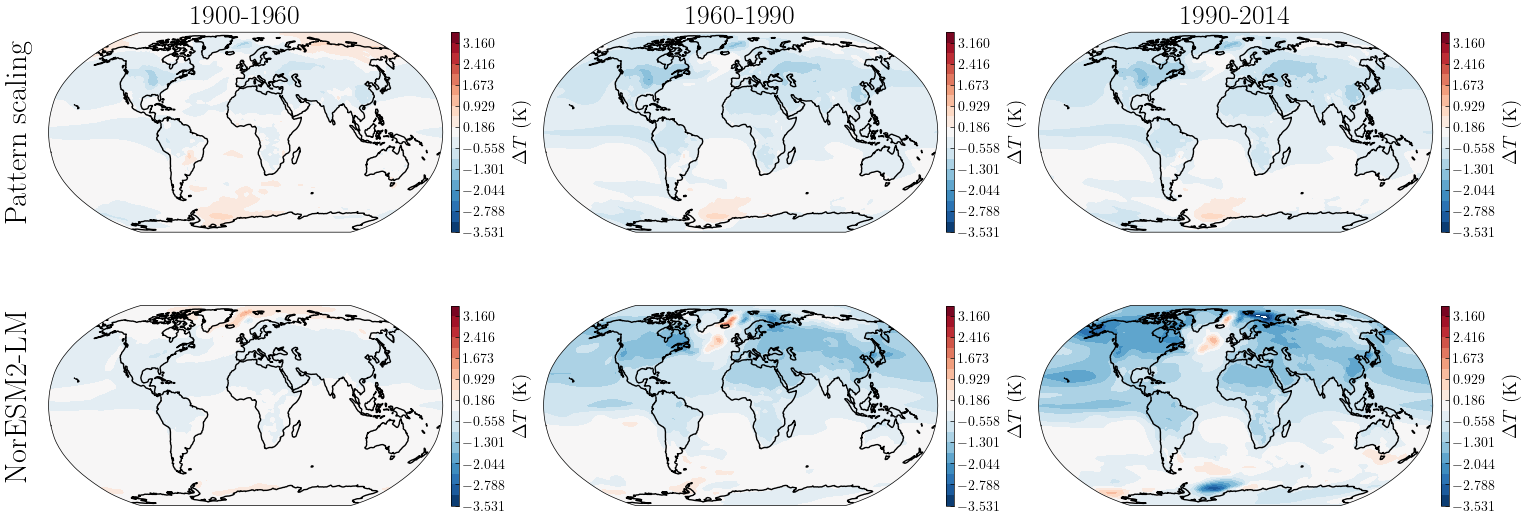

In [8]:
years = [(1900, 1960), (1960, 1990), (1990, 2014)]

ncol = len(years)
vmax = max(pred.max(), test_tas.max())

fig, ax = plt.subplots(2, ncol, figsize=(ncol * 5, 2 * 3), subplot_kw={'projection': ccrs.Robinson()})

for i in range(ncol):
    start, end = years[i]
    time_slice = slice(start, end)
    
    _, __, cbar = vis.plot_contourf_on_ax(xr_pred.sel(time=time_slice).mean(dim='time'), 
                                          fig, ax[0, i], colorbar=True, vmax=vmax)
    cbar.set_label(r'$\Delta T$ (K)', fontsize=14)
#     cbar.set_ticks([-4, -2, 0, 2, 4])
    
    _, __, cbar = vis.plot_contourf_on_ax(xr_groundtruth.sel(time=time_slice).mean(dim='time'), 
                                          fig, ax[1, i], colorbar=True, vmax=vmax)
    cbar.set_label(r'$\Delta T$ (K)', fontsize=14)
#     cbar.set_ticks([-4, -2, 0, 2, 4])
    ax[0, i].set_title(f'{start}-{end}', fontsize=20)

fig.text(-0.01, 0.72, 'Pattern scaling', ha='center', va='center', rotation='vertical', fontsize=22)
fig.text(-0.01, 0.28, 'NorESM2-LM', ha='center', va='center', rotation='vertical', fontsize=22)

plt.tight_layout()
# plt.savefig('./figures/comparison-spatial-forcing-posterior-paper-figure.png', dpi=200)
plt.show()

## Plain GP

In [9]:
model = plaingp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/all-ssps/SpatialPlainGP/state_dict.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [10]:
Xtest = test_scenarios.glob_inputs[:, 1:]
Xtest = (Xtest - model.mu) / model.sigma
test_tas = test_scenarios.tas
model = model.eval()

In [11]:
with torch.no_grad():
    posterior = model.posterior(Xtest, diag=False)
    posterior = model.likelihood(posterior)

In [12]:
nlat = len(test_scenarios[0].lat)
nlon = len(test_scenarios[0].lon)
ntimes = len(test_scenarios[0].timesteps)

prior_mean = model.mu_targets.view(1, nlat, nlon).repeat(ntimes, 1, 1)
posterior_mean = posterior.mean.reshape(nlat, nlon, -1).permute(2, 0, 1)
posterior_correction =  model.sigma_targets.view(1, nlat, nlon) * posterior_mean
posterior_mean = prior_mean + posterior_mean

posterior_stddev = posterior.stddev.reshape(nlat, nlon, -1).permute(2, 0, 1)
posterior_stddev = model.sigma_targets.view(1, nlat, nlon) * posterior_stddev
posterior_ub = posterior_mean + 2 * posterior_stddev
posterior_lb = posterior_mean - 2 * posterior_stddev

In [13]:
xr_prior_mean = encapsulate(prior_mean)
xr_posterior_correction = encapsulate(posterior_correction)
xr_posterior_mean = encapsulate(posterior_mean)
xr_posterior_ub = encapsulate(posterior_ub)
xr_posterior_lb = encapsulate(posterior_lb)
xr_groundtruth = encapsulate(test_tas)

# xr_posterior_mean.to_netcdf('./netcdf/hist_aer_plain_gp.nc')

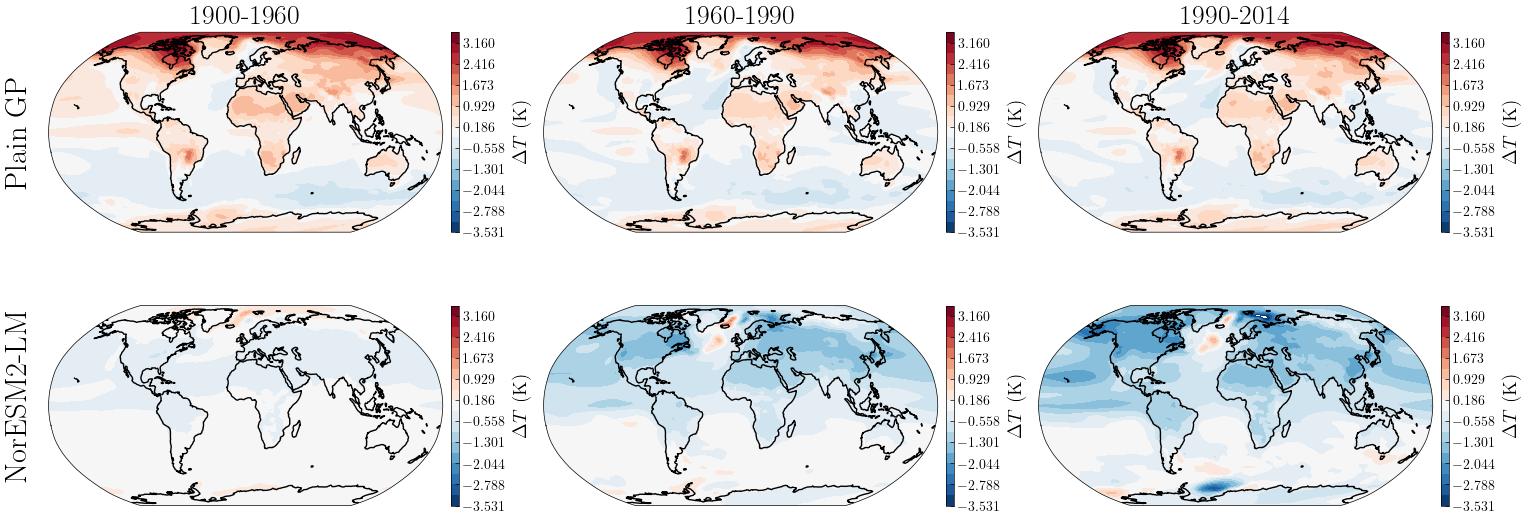

In [14]:
years = [(1900, 1960), (1960, 1990), (1990, 2014)]

ncol = len(years)
vmax = max(pred.max(), test_tas.max())

fig, ax = plt.subplots(2, ncol, figsize=(ncol * 5, 2 * 3), subplot_kw={'projection': ccrs.Robinson()})

for i in range(ncol):
    start, end = years[i]
    time_slice = slice(start, end)
    
    _, __, cbar = vis.plot_contourf_on_ax(xr_posterior_mean.sel(time=time_slice).mean(dim='time'), 
                                          fig, ax[0, i], colorbar=True, vmax=vmax)
    cbar.set_label(r'$\Delta T$ (K)', fontsize=14)
#     cbar.set_ticks([-4, -2, 0, 2, 4])
    
    _, __, cbar = vis.plot_contourf_on_ax(xr_groundtruth.sel(time=time_slice).mean(dim='time'), 
                                          fig, ax[1, i], colorbar=True, vmax=vmax)
    cbar.set_label(r'$\Delta T$ (K)', fontsize=14)
#     cbar.set_ticks([-4, -2, 0, 2, 4])
    ax[0, i].set_title(f'{start}-{end}', fontsize=20)

fig.text(-0.01, 0.72, 'Plain GP', ha='center', va='center', rotation='vertical', fontsize=22)
fig.text(-0.01, 0.28, 'NorESM2-LM', ha='center', va='center', rotation='vertical', fontsize=22)

plt.tight_layout()
# plt.savefig('./figures/comparison-spatial-forcing-posterior-paper-figure.png', dpi=200)
plt.show()

## FaIRGP

In [15]:
model = fairgp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/all-ssps/SpatialFaIRGP/state_dict.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [16]:
test_tas = test_scenarios.tas

model = model.eval()
with torch.no_grad():
    posterior = model.posterior(test_scenarios, diag=False)
    posterior = model.likelihood(posterior)

In [17]:
nlat = len(test_scenarios[0].lat)
nlon = len(test_scenarios[0].lon)
prior_mean = model._compute_means(test_scenarios, use_aci=True)['hist-aer']
posterior_mean = posterior.mean.reshape(nlat, nlon, -1).permute(2, 0, 1)
posterior_correction = model.mu_targets + model.sigma_targets * posterior_mean
posterior_correction = model.beta.unsqueeze(0) * posterior_correction
posterior_mean = prior_mean + posterior_correction

posterior_stddev = posterior.stddev.reshape(nlat, nlon, -1).permute(2, 0, 1)
posterior_stddev = model.sigma_targets * posterior_stddev * torch.abs(model.beta.unsqueeze(0))
posterior_ub = posterior_mean + 2 * posterior_stddev
posterior_lb = posterior_mean - 2 * posterior_stddev

In [18]:
xr_prior_mean = encapsulate(prior_mean)
xr_posterior_correction = encapsulate(posterior_correction)
xr_posterior_mean = encapsulate(posterior_mean)
xr_posterior_ub = encapsulate(posterior_ub)
xr_posterior_lb = encapsulate(posterior_lb)
xr_groundtruth = encapsulate(test_tas)

# xr_posterior_mean.to_netcdf('./netcdf/hist_aer_fairgp.nc')

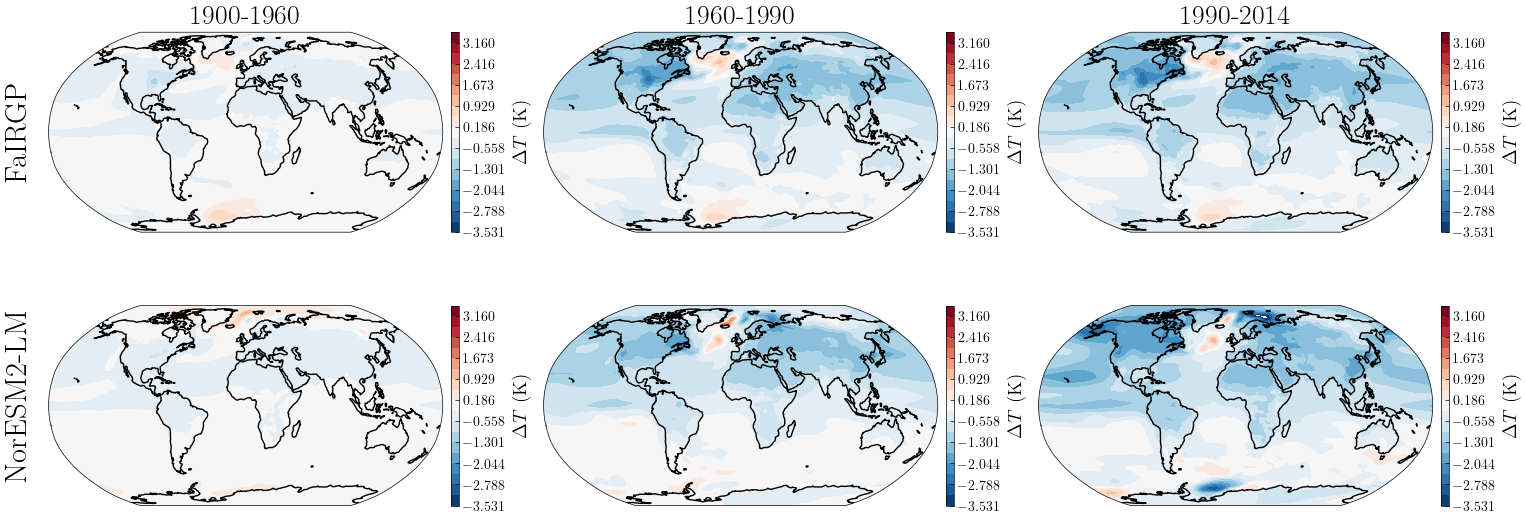

In [19]:
years = [(1900, 1960), (1960, 1990), (1990, 2014)]

ncol = len(years)
vmax = max(pred.max(), test_tas.max())

fig, ax = plt.subplots(2, ncol, figsize=(ncol * 5, 2 * 3), subplot_kw={'projection': ccrs.Robinson()})

for i in range(ncol):
    start, end = years[i]
    time_slice = slice(start, end)
    
    _, __, cbar = vis.plot_contourf_on_ax(xr_posterior_mean.sel(time=time_slice).mean(dim='time'), 
                                          fig, ax[0, i], colorbar=True, vmax=vmax)
    cbar.set_label(r'$\Delta T$ (K)', fontsize=14)
#     cbar.set_ticks([-4, -2, 0, 2, 4])
    
    _, __, cbar = vis.plot_contourf_on_ax(xr_groundtruth.sel(time=time_slice).mean(dim='time'), 
                                          fig, ax[1, i], colorbar=True, vmax=vmax)
    cbar.set_label(r'$\Delta T$ (K)', fontsize=14)
#     cbar.set_ticks([-4, -2, 0, 2, 4])
    ax[0, i].set_title(f'{start}-{end}', fontsize=20)

fig.text(-0.01, 0.72, 'FaIRGP', ha='center', va='center', rotation='vertical', fontsize=22)
fig.text(-0.01, 0.28, 'NorESM2-LM', ha='center', va='center', rotation='vertical', fontsize=22)

plt.tight_layout()
# plt.savefig('./figures/comparison-spatial-forcing-posterior-paper-figure.png', dpi=200)
plt.show()